In [1]:
import torch
import torchvision

In [ ]:
## Specifying the constants in the script

In [2]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [ ]:
## Creating a dataloader.

In [3]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [5]:
example_data.shape

torch.Size([1000, 1, 28, 28])

In [ ]:
## These are the ground truth values plotted against the images, which form a part of the training set.

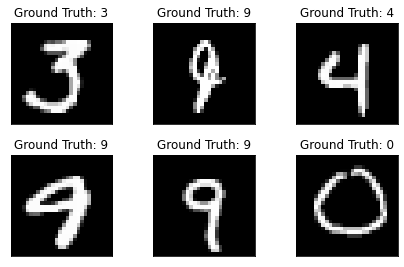

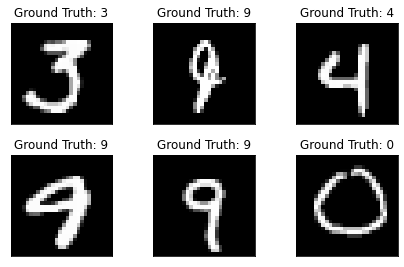

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
## This is the NN model that we train for this multi-class classification task

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [9]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [10]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [14]:
% mkdir results

In [15]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    ## We use a cross-entropy loss function here
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), '/content/results/model.pth')
      torch.save(optimizer.state_dict(), '/content/results/optimizer.pth')

In [16]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [17]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3084, Accuracy: 923/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.324247
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.273413
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.252027
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.279411
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.259859
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.255871
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.175713
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.212805
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.093185
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.029723
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.901314
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.907668
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.777701
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.564114
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.368979
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.345801
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.409030
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.169695
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.430620
Train Epoch: 1 [12160/6

In [18]:
with torch.no_grad():
  output = network(example_data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
## Predictions based on the trained model

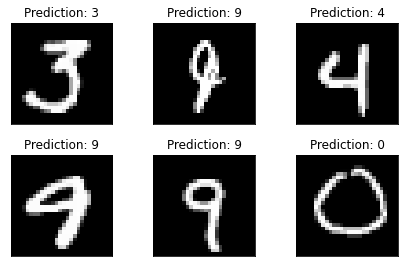

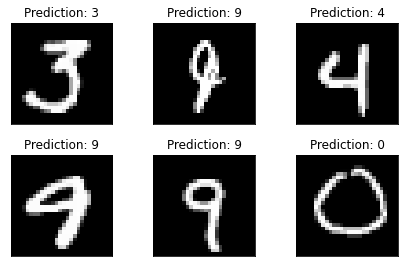

In [19]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

In [ ]:
## output is of size (no of examples, no of classes) and contains probabilities of the example belonging to each of the classes. Each row sums up to 1.
## Here the no of classes = 10 and no of examples in this batch = 1000

In [ ]:
print(output.shape)

torch.Size([1000, 10])


In [ ]:
print(output[:6, :])

tensor([[-1.9541e+01, -1.4408e+01, -1.6725e+01, -3.0799e-04, -1.9366e+01,
         -8.1346e+00, -2.3316e+01, -1.7116e+01, -1.4072e+01, -1.1221e+01],
        [-1.2813e+01, -5.1221e+00, -7.9929e+00, -6.3194e+00, -1.2280e+00,
         -9.1447e+00, -1.1793e+01, -4.1599e+00, -2.4306e+00, -5.1868e-01],
        [-2.5717e+01, -2.3565e+01, -1.8356e+01, -1.9909e+01, -5.0139e-04,
         -1.8096e+01, -1.9151e+01, -1.9632e+01, -1.7388e+01, -7.5984e+00],
        [-1.7424e+01, -2.2231e+01, -1.6736e+01, -1.1927e+01, -6.8917e+00,
         -1.3437e+01, -2.2672e+01, -5.9404e+00, -1.0821e+01, -3.6821e-03],
        [-1.7561e+01, -2.0147e+01, -1.7535e+01, -1.0714e+01, -8.7181e+00,
         -1.1485e+01, -2.2103e+01, -7.6697e+00, -7.4174e+00, -1.2644e-03],
        [-7.3857e-03, -1.2955e+01, -5.7936e+00, -9.4461e+00, -1.4488e+01,
         -9.0481e+00, -5.5210e+00, -1.5444e+01, -9.2829e+00, -1.0991e+01]])


In [ ]:
## We take max over each row to determine the class for each example

In [ ]:
print(torch.argmax(output[:6, :], axis=1))

tensor([3, 9, 4, 9, 9, 0])
